<a href="https://www.kaggle.com/code/dmid2qwde/simahin?scriptVersionId=94043230" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
import numpy as np 
import pandas as pd 
import re
import emoji
import string
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/fake-news/test.tsv
/kaggle/input/fake-news/train.tsv


In [2]:
# считывание файлов в датасеты
train = pd.read_csv('../input/fake-news/train.tsv',sep='\t',encoding="utf-8")
test = pd.read_csv('../input/fake-news/test.tsv', sep = '\t',encoding="utf-8")
# создание копии тестового набора, т.к. у меня будет два файла решения
test_copy = test.copy(deep=True)

In [3]:
train.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [4]:

train.shape

(5758, 2)

In [5]:
test.shape

(1000, 2)

In [6]:
# проверка на наличие пропусков и кол-во значений в датасетах
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [7]:
# проверка на дупликаты
print('train duplicated - {}'.format(train.duplicated().sum()))
print('test duplicated - {}'.format(test.duplicated().sum()))

train duplicated - 1
test duplicated - 0


In [8]:
# удаление дупликатов
train = train.drop_duplicates()
print('train duplicated - {}'.format(train.duplicated().sum()))

train duplicated - 0


In [9]:


# удаление ненужных знаков
def strip_all_entities(text): 
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text =text.replace('»', "").replace('«', "")
    text =text.replace('“', "").replace('”', "")
    text = re.sub(r"\d+", "", text, flags=re.UNICODE)
    text =' '.join(word for word in text.split() if len(word) > 2) # убираем слова, где меньше трех букв
    return text


#Stemming
def stemmer(text):
    stemmer = PorterStemmer()
    stop = set(stopwords.words('russian')) #убираем русские стоп-слова
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop: #делаем все слова строчными буквами
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text) 

#функция, применяющая функции очистки по порядку
def deep_clean(text):
    text = strip_all_entities(text)
    text = stemmer(text)
    return text

In [10]:
# применяем функцию очистки
texts_clean = []
for t in train.title:
    texts_clean.append(deep_clean(t))

In [11]:
# пример очищенных новостей
texts_clean[:10]

['москвичу владимиру клутину пришёл счёт вмешательство американские выборы',
 'агент кокорина назвал езду встречке житейской историей',
 'госдума рассмотрит возможность введения секретных статей уголовного кодекса',
 'фас заблокировала поставку скоростных трамваев москвы',
 'против навального завели дело недоносительстве волкова',
 'российским студентам запретят учиться рубежом',
 'путин пишет книгу истории украины',
 'россияне обхитрили рост цен',
 'звезда ворониных раскрыл подробности своем состоянии',
 'microsoft объявила дату выхода очков дополненной реальности hololen']

In [12]:
train['texts_clean'] = texts_clean

In [13]:
# очищаем тестовый набор
texts_clean = []
for t in test.title:
    texts_clean.append(deep_clean(t))

In [14]:

test['texts_clean'] = texts_clean

In [15]:
# измеряем длину каждой новости
texts_lens = []
for text in train.title:
    doc_len = len(text.split())
    texts_lens.append(doc_len)
    
train['texts_lens'] = texts_lens

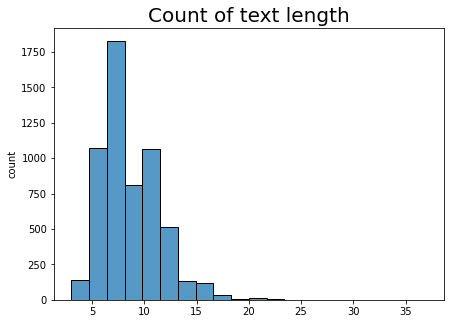

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# распределение длины новостей
plt.figure(figsize=(7,5))
ax = sns.histplot(x='texts_lens', data=train, palette='mako',bins=20)
plt.title('Count of text length', fontsize=20)
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [17]:
import plotly.graph_objs as go
import plotly.offline as py
# распреление таргетной переменной 
data = [go.Bar(
            x = train.is_fake.unique(),
            y = train.is_fake.value_counts().values,
            marker= dict(colorscale='RdBu',
                         color = train.is_fake.value_counts().values
                        ),
            
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')


In [18]:
# топ 15 слов по частоте употребления в тренировочном датасете
all_words = train['texts_clean'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[0:15],
            y = all_words.values[0:15],
            marker= dict(colorscale='RdBu',
                         color = all_words.values[0:150]
                        ),
            
    )]

layout = go.Layout(
    title='Top 15  Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [19]:
# разделение тренировочного датасета на train test для обучения
from sklearn.model_selection import train_test_split, cross_val_score
y=train['is_fake']
xtrain, xvalid, ytrain, yvalid = train_test_split(train.texts_clean.values, y, 
                                                  stratify=y, 
                                                  random_state=17, 
                                                  test_size=0.2, shuffle=True)

In [20]:
train.texts_clean

0       москвичу владимиру клутину пришёл счёт вмешате...
1       агент кокорина назвал езду встречке житейской ...
2       госдума рассмотрит возможность введения секрет...
3       фас заблокировала поставку скоростных трамваев...
4       против навального завели дело недоносительстве...
                              ...                        
5753     эдди чемберс получил сотрясение мозга бою кличко
5754    правительство застроит россию нефтепродуктопро...
5755    стыдно дедом новый канцлер фрг обратился перво...
5756         туркмения декабре начнет поставки газа китай
5757    бывший тренер локомотива возглавил нальчикский...
Name: texts_clean, Length: 5757, dtype: object

In [21]:
# объявление TfidfVectorizer для дальнейшего преобразования символов в вектор
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)



In [22]:
# преобразование данных в числовой вектор
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [23]:
# получаем разреженную матрицу
xtrain_tfv

<4605x3801 sparse matrix of type '<class 'numpy.float64'>'
	with 19886 stored elements in Compressed Sparse Row format>

In [24]:

feature_names = tfv.get_feature_names_out()
len(feature_names)

3801

In [25]:

feature_names

array(['airbu', 'airway', 'amd', ..., 'японские', 'японского', 'яровая'],
      dtype=object)

In [26]:
# наименование таргетных переменных для отображения в classification report
target=['Real','Fake']

              precision    recall  f1-score   support

        Real       0.80      0.83      0.81       576
        Fake       0.83      0.79      0.81       576

    accuracy                           0.81      1152
   macro avg       0.81      0.81      0.81      1152
weighted avg       0.81      0.81      0.81      1152



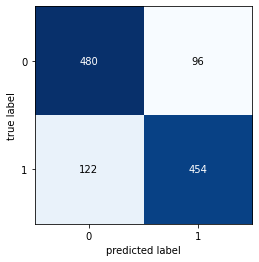

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
# применение логистической регрессии для классификации
LR = LogisticRegression(C=1.0)
LR.fit(xtrain_tfv, ytrain)
predictions = LR.predict(xvalid_tfv)

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [28]:
# проверка логистической регрессии на кросс-валидации
cv_results = cross_val_score(LR, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.7979178876398751

              precision    recall  f1-score   support

        Real       0.71      0.84      0.77       576
        Fake       0.80      0.66      0.72       576

    accuracy                           0.75      1152
   macro avg       0.75      0.75      0.74      1152
weighted avg       0.75      0.75      0.74      1152



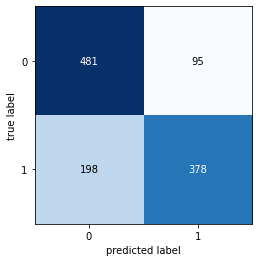

In [29]:
# применение xgboost для классификации
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=15, n_estimators=500, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, use_label_encoder=False)
clf.fit(xtrain_tfv.tocsc(), ytrain,eval_metric='mae')
predictions = clf.predict(xvalid_tfv.tocsc())

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [30]:
# проверка xgboost на кросс-валидации
cv_results = cross_val_score(clf, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.7040360179154898

              precision    recall  f1-score   support

        Real       0.82      0.81      0.81       576
        Fake       0.81      0.82      0.82       576

    accuracy                           0.82      1152
   macro avg       0.82      0.82      0.82      1152
weighted avg       0.82      0.82      0.82      1152



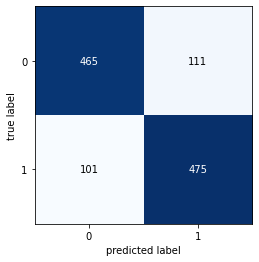

In [31]:
# применение MultinomialNB для классификации
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [32]:
# проверка наивного байеса на кросс-валидации
cv_results = cross_val_score(clf, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.8063467528881889

              precision    recall  f1-score   support

        Real       0.79      0.91      0.84       576
        Fake       0.89      0.75      0.82       576

    accuracy                           0.83      1152
   macro avg       0.84      0.83      0.83      1152
weighted avg       0.84      0.83      0.83      1152



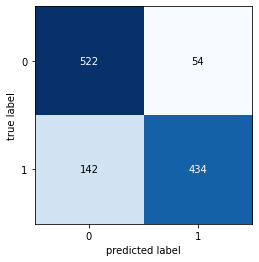

In [33]:
# применение BernoulliNB для классификации
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [34]:
# проверка BernoulliNB на кросс-валидации
cv_results = cross_val_score(clf, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.805325123639529

              precision    recall  f1-score   support

        Real       0.82      0.84      0.83       576
        Fake       0.83      0.82      0.83       576

    accuracy                           0.83      1152
   macro avg       0.83      0.83      0.83      1152
weighted avg       0.83      0.83      0.83      1152



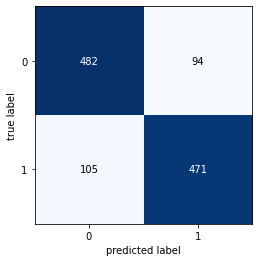

In [35]:
# применение ComplementNB для классификации
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [36]:
# проверка ComplementNB на кросс-валидации
cv_results = cross_val_score(clf, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.8082134837340634

              precision    recall  f1-score   support

        Real       0.65      0.91      0.76       576
        Fake       0.85      0.52      0.64       576

    accuracy                           0.71      1152
   macro avg       0.75      0.71      0.70      1152
weighted avg       0.75      0.71      0.70      1152



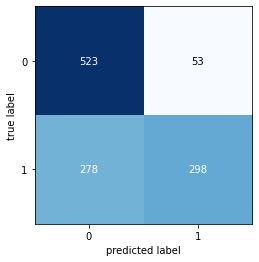

In [37]:
# применение RandomForestClassifier для классификации
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=50,n_estimators=150)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [38]:
# проверка RandomForest на кросс-валидации
cv_results = cross_val_score(clf, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.6241251766269944

              precision    recall  f1-score   support

        Real       0.74      0.78      0.76       576
        Fake       0.77      0.73      0.75       576

    accuracy                           0.76      1152
   macro avg       0.76      0.76      0.76      1152
weighted avg       0.76      0.76      0.76      1152



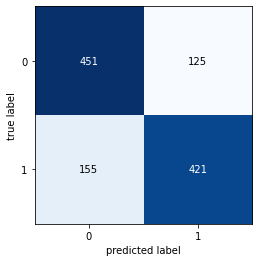

In [39]:
# проверка PassiveAggressiveClassifier на кросс-валидации
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(max_iter=50)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [40]:
# проверка PassiveAggressiveClassifier на кросс-валидации
cv_results = cross_val_score(clf, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.7686626118429094

              precision    recall  f1-score   support

        Real       0.80      0.82      0.81       576
        Fake       0.81      0.80      0.80       576

    accuracy                           0.81      1152
   macro avg       0.81      0.81      0.81      1152
weighted avg       0.81      0.81      0.81      1152



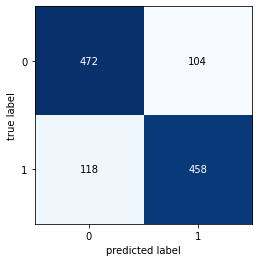

In [41]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

# интерпретация результатов в виде confusion matrix и classification report
print ( classification_report(yvalid, predictions,target_names=target))
cm = metrics.confusion_matrix(yvalid,predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [42]:
# проверка SVC на кросс-валидации
cv_results = cross_val_score(clf, # Конвейер
                             xtrain_tfv, # Матрица признаков
                             ytrain, # Вектор целей
                             cv=5, # Метод перекрестной проверки
                             scoring='f1', # Функция потери
                             n_jobs=-1) # Использовать все ядра CPU
cv_results.mean()

0.8050588154735745

In [43]:
# объявляем библиотеки для дальнейего построения модели
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [44]:
# объявляем и фитим токенайзер и находим длину словаря
t = Tokenizer()
t.fit_on_texts(train['texts_clean'])
vocab_size = len(t.word_index) + 1

In [45]:
# получаем токены для train и test
list_tokenized_train=t.texts_to_sequences(xtrain)
list_tokenized_test=t.texts_to_sequences(xvalid)


In [46]:
# объявляем максимальную длину 40, т.к. до этого на визуализации посмотрели распределения длин документов
maxlen = 40
# заполняем нулями для формирования матрицы
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)


In [47]:
# подаем на вход maxlen 
inp = Input(shape=(maxlen, ))
embed_size = 100
# объявляем слои нейронной сети
x = Embedding(vocab_size, embed_size)(inp)
x = LSTM(100, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
# функции активации
x = Dense(50, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)

2022-04-26 09:58:25.063084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 09:58:25.064420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 09:58:25.065149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 09:58:25.066013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [48]:

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=['accuracy'])

In [49]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 100)           1832800   
_________________________________________________________________
lstm_layer (LSTM)            (None, 40, 100)           80400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51    

In [50]:

model.fit(X_t,ytrain, batch_size=32, epochs=10, validation_split=0.1)

2022-04-26 09:58:32.731685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-26 09:58:35.097074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


130/130 [==============================] - 5s 13ms/step - loss: 0.5642 - accuracy: 0.6863 - val_loss: 0.3700 - val_accuracy: 0.8221
Epoch 2/10
130/130 [==============================] - 1s 6ms/step - loss: 0.1396 - accuracy: 0.9520 - val_loss: 0.3793 - val_accuracy: 0.8503
Epoch 3/10
130/130 [==============================] - 1s 6ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.4722 - val_accuracy: 0.8633
Epoch 4/10
130/130 [==============================] - 1s 6ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.5460 - val_accuracy: 0.8568
Epoch 5/10
130/130 [==============================] - 1s 6ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.5685 - val_accuracy: 0.8590
Epoch 6/10
130/130 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.6149 - val_accuracy: 0.8568
Epoch 7/10
130/130 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.6126 - val_accuracy: 0.8612
Epoch 8/10
130/1

In [51]:
# вывод точности модели
loss,acc = model.evaluate(X_te,yvalid, verbose = 0, batch_size = 32)
print("acc: %.5f" % (acc))

acc: 0.82986


In [52]:
# готовим тестовые данные для предсказания
t.fit_on_texts(test['texts_clean'])
list_tokenized_valid=t.texts_to_sequences(test['texts_clean'])

In [53]:
# убираем колонку с очищенными новостями
test = test.drop(columns=['texts_clean'])

In [54]:
# получение разреженной матрицы
X_val = pad_sequences(list_tokenized_valid, maxlen=40)

In [55]:
X_val

array([[    0,     0,     0, ..., 18400,  3864,     1],
       [    0,     0,     0, ...,  1157,  1372,    25],
       [    0,     0,     0, ...,   313,  6669,   227],
       ...,
       [    0,     0,     0, ...,   752,  2911,     9],
       [    0,     0,     0, ...,   788, 20271,  3813],
       [    0,     0,     0, ...,  6853, 20273,   176]], dtype=int32)

In [56]:
# я решил вывести два решения MNB и LSTM
clf_final_1 = MultinomialNB()
clf_final_1.fit(X_t, ytrain)
pred_1 = clf_final_1.predict(X_val)

In [57]:
# получаем метки классов для MNB
pred_1[:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [58]:
# заполняем колонку предсказанными значениями
test['is_fake']=pred_1

In [59]:
test.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0


In [60]:
test['is_fake'].value_counts()

0    779
1    221
Name: is_fake, dtype: int64

In [61]:
# сохранение полученного результата
test.to_csv('predictions_MNB.tsv')

In [62]:
# LSTM
pred_2 = model.predict(X_val)

In [63]:
# получаем вероятности 
pred_2[:10]

array([[0.9958405 ],
       [0.999997  ],
       [0.9782015 ],
       [0.9999962 ],
       [0.99999297],
       [0.9999987 ],
       [0.9994937 ],
       [0.9999969 ],
       [0.02970417],
       [0.86747074]], dtype=float32)

In [64]:
# заполняем массив прогноза исходя из полученных вероятностей
binary_predictions_LSTM = []

for i in pred_2:
    if i >= 0.5:
        binary_predictions_LSTM.append(1)
    else:
        binary_predictions_LSTM.append(0) 

In [65]:
# заполняем колонку предсказанными значениями
test_copy['is_fake']=binary_predictions_LSTM

In [66]:
test_copy['is_fake'].value_counts()

1    613
0    387
Name: is_fake, dtype: int64

In [67]:
# сохранение полученного результата
test_copy.to_csv('predictions_LSTM.tsv')